In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%config Inlinebackground.figureFormat='retina'
sns.set(font_scale=1.75)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
# loading the datasets from text files
# cab data
cab_data = pd.read_csv(r'uber-lyft-cab-prices/Cab-Weather Data/Cab-Weather Data/cab_rides.txt', encoding='utf-16')
# weather data
weather_data = pd.read_csv(r'uber-lyft-cab-prices/Cab-Weather Data/Cab-Weather Data/weather.txt', encoding='utf-16')

### Missing Value Treatment

#### Cab Dataset

In [4]:
rows, cols = cab_data.shape
print(f'Cab ride dataset contains {rows} rows and {cols} columns.')

Cab ride dataset contains 693071 rows and 10 columns.


In [5]:
missing  = cab_data.isnull().sum().sum()
percent = round(((missing/cab_data.shape[0]) * 100),2)
print(f'Cab dataset contains {missing} missing values, which is {percent} % of whole data.')

Cab dataset contains 55095 missing values, which is 7.95 % of whole data.


In [6]:
cab_data.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

The missing values are present in the price column. We can convert these rows into validation set or check for reasons for missing data. Let's see if the missing values have some pattern or they occur at random.

In [7]:
# Check on cab type
cab_data[cab_data['price'].isnull()]['cab_type'].value_counts() 

Uber    55095
Name: cab_type, dtype: int64

We can see that, the missing values are present only in the Uber data. Let's also check the car type and model.

In [8]:
cab_data[cab_data['cab_type']=='Uber'].name.value_counts()

Black SUV    55096
UberXL       55096
WAV          55096
Taxi         55095
Black        55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

In [9]:
cab_data[cab_data['price'].isnull()]['name'].value_counts() # car model

Taxi    55095
Name: name, dtype: int64

We see that all missing values belong to cab type = Taxi, Uber official website has no mention of this model and the missing values are less than 10% of the original data, hence we have can drop the records containing missing values.

In [10]:
#dropping the records
cab_data = cab_data.dropna()
rows, cols = cab_data.shape
print(f'Now the dataset contains {rows} rows and {cols} columns.')

Now the dataset contains 637976 rows and 10 columns.


In [11]:
cab_data.isnull().sum().sum() # check for missing values

0

In [12]:
cab_data = cab_data.sample(n=100000) # needs to be reverted at the end
cab_data.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
365088,2.27,Uber,1543821780778,Boston University,Beacon Hill,8.5,1.0,fd1302f0-4d9b-417e-a436-fa262b3e97af,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV
579620,2.19,Uber,1543667880638,North End,Beacon Hill,8.0,1.0,2c456287-33b0-4159-8c68-6daab0a7202f,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool
355298,1.41,Uber,1544780406716,Boston University,Back Bay,7.5,1.0,58d4542b-1566-486c-973f-79cffebc9517,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX


In [13]:
weather_data.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07


**Weather dataset**

In [14]:
rows, cols = weather_data.shape
print(f'weather dataset contains {rows} rows and {cols} columns.')

weather dataset contains 6276 rows and 8 columns.


In [15]:
missing  = weather_data.isnull().sum().sum()
percentage = round(((missing/weather_data.shape[0]) * 100),3)
print(f'weather dataset contains {missing} missing values, which is {percentage} % of whole data.')

weather dataset contains 5382 missing values, which is 85.755 % of whole data.


In [16]:
weather_data.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

We observed that the 'rain' feature has 85.75 % of the data as missing. After checking the weather conditions for that duration we can infer that the missing values are due to unobserved input variable, hence we will impute the missing values with zero, which denotes no rain.

In [17]:
# let's impute the missing values in the 'rain' column with 0
weather_data['rain'].fillna(0, inplace=True)

In [18]:
weather_data.isnull().sum().sum() # check for missing values

0

## Atrribute information

**Dependent variables**:       

    Distance - distance between source and destination             
    Cab_type - Uber or Lyft                 
    Time_stamp - epoch time when data was queried              
    Destination - destination of the ride              
    Source - the starting point of the ride              
    Surge_multiplier - the multiplier by which price was increased, default 1              
    Id - unique identifier              
    Product_id - uber/lyft identifier for cab-type              
    Name - Visible type of the cab eg: Uber Pool, UberXL              

**Target variable**:               

    Price - price estimate for the ride in USD

### Feature category        
**Categorical**       
    - Cab type
    - Destination
    - Source
    - Product Id
    - Name
    - Id
    - Surge Multiplier
    
**Continuous**     
    - Distance
    - Time stamp
    - Price

# Exploratory Data Analysis

In [19]:
# let's impute the time to standard date time format
cab_data['time_stamp'] = pd.to_datetime(cab_data['time_stamp'], unit='ms')
cab_data['date'] = cab_data['time_stamp'].dt.date  # extract date
cab_data['hour'] = cab_data['time_stamp'].dt.hour  # extract hour

cab_data.drop('time_stamp', axis=1, inplace=True)  # drop time_stamp feature

# splitting the dataset for easy access
uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

cab_data.head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
365088,2.27,Uber,Boston University,Beacon Hill,8.5,1.0,fd1302f0-4d9b-417e-a436-fa262b3e97af,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-12-03,7
579620,2.19,Uber,North End,Beacon Hill,8.0,1.0,2c456287-33b0-4159-8c68-6daab0a7202f,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-12-01,12
355298,1.41,Uber,Boston University,Back Bay,7.5,1.0,58d4542b-1566-486c-973f-79cffebc9517,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-12-14,9


## Univariate analysis

### Continuous variables

**Distance , Price and Surge Multiplier**

In [20]:
# Uber and Lyft data indexes
all_data=cab_data['cab_type']!=0 
lyft_data=cab_data['cab_type']=='Lyft'
uber_data=cab_data['cab_type']=='Uber'

In [21]:
#function for describing each variable
def col_description(*args,ls):
    for x in args:
        a=cab_data[x].loc[:,ls].apply(lambda x : x.describe(),axis=0)
        print(a)
        print()

In [22]:
num_lst=['distance','price','surge_multiplier']
col_description(all_data,uber_data,lyft_data,ls=num_lst) # gives column description for each dataframe passed

            distance          price  surge_multiplier
count  100000.000000  100000.000000     100000.000000
mean        2.191725      16.532236          1.014657
std         1.136841       9.307017          0.092909
min         0.020000       2.500000          1.000000
25%         1.270000       9.000000          1.000000
50%         2.170000      13.500000          1.000000
75%         2.940000      22.500000          1.000000
max         7.860000      97.500000          3.000000

           distance         price  surge_multiplier
count  51846.000000  51846.000000           51846.0
mean       2.191533     15.807179               1.0
std        1.178474      8.558169               0.0
min        0.020000      4.500000               1.0
25%        1.300000      9.000000               1.0
50%        2.170000     12.500000               1.0
75%        2.860000     21.500000               1.0
max        7.860000     89.500000               1.0

           distance         price  surge_mul

In [23]:
cat_lst=['destination','source','name'] # dropped factor variables which were not useful
col_description(all_data,uber_data,lyft_data,ls=cat_lst) # gives column description for each dataframe passed

               destination              source    name
count               100000              100000  100000
unique                  12                  12      12
top     Financial District  Financial District   Black
freq                  8589                8584    8747

               destination              source   name
count                51846               51846  51846
unique                  12                  12      6
top     Financial District  Financial District  Black
freq                  4463                4457   8747

               destination              source     name
count                48154               48154    48154
unique                  12                  12        6
top     Financial District  Financial District  Lyft XL
freq                  4126                4127     8146



In [24]:
# function to perform basic EDA for input columns
def EDA_function(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.distplot(df[lyft_data], ax=ax1, kde=True)
    ax1.set_title('Distribution of '+df.name+' in Lyft', fontsize=20)
    sns.distplot(df[uber_data], ax=ax2)
    ax2.set_title('Distribution of '+df.name+' in Uber', fontsize=20)
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    sns.boxplot(df[lyft_data], ax=ax1)
    ax1.set_title('Boxplot for '+df.name+' in Lyft', fontsize=20)
    sns.boxplot(df[uber_data], ax=ax2)
    ax2.set_title('Boxplot for '+df.name+' in Uber', fontsize=20)
    return(1)

C:\Users\himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


distance            1
price               1
surge_multiplier    1
dtype: int64

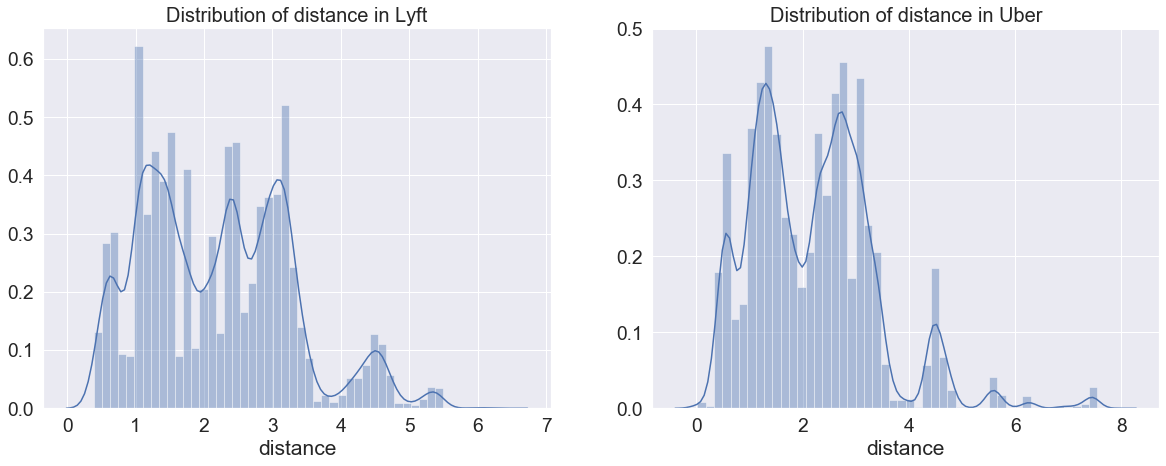

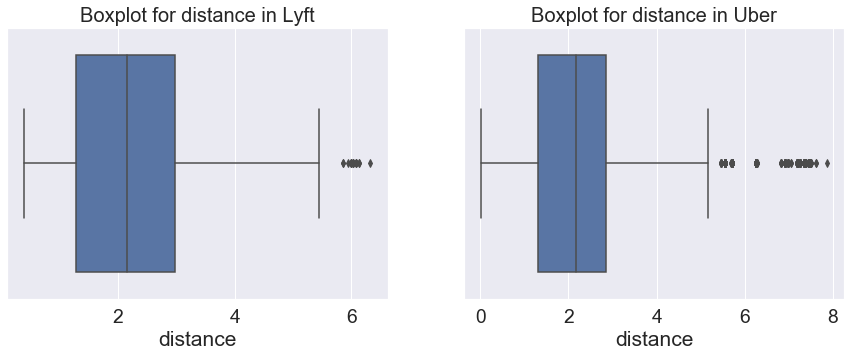

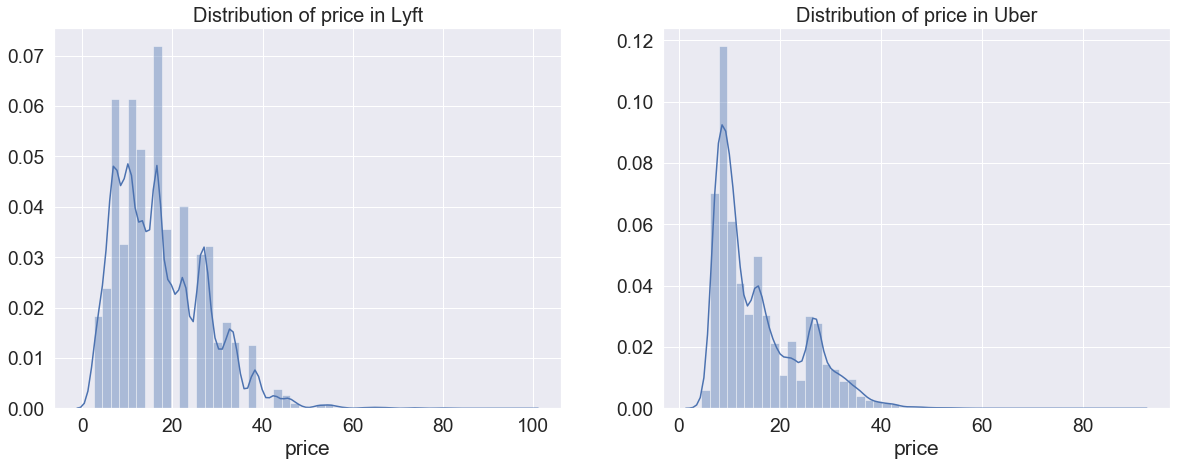

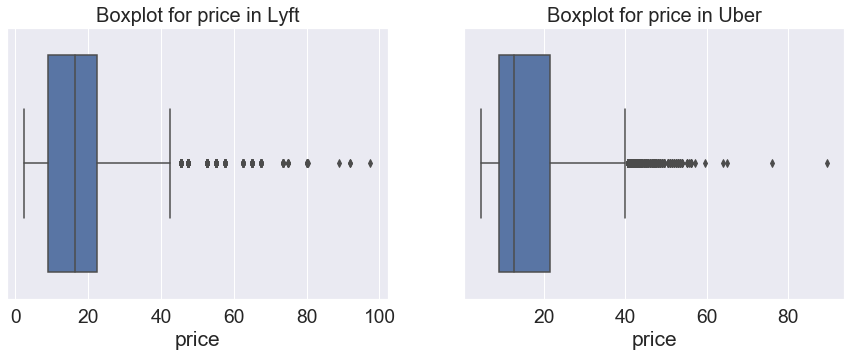

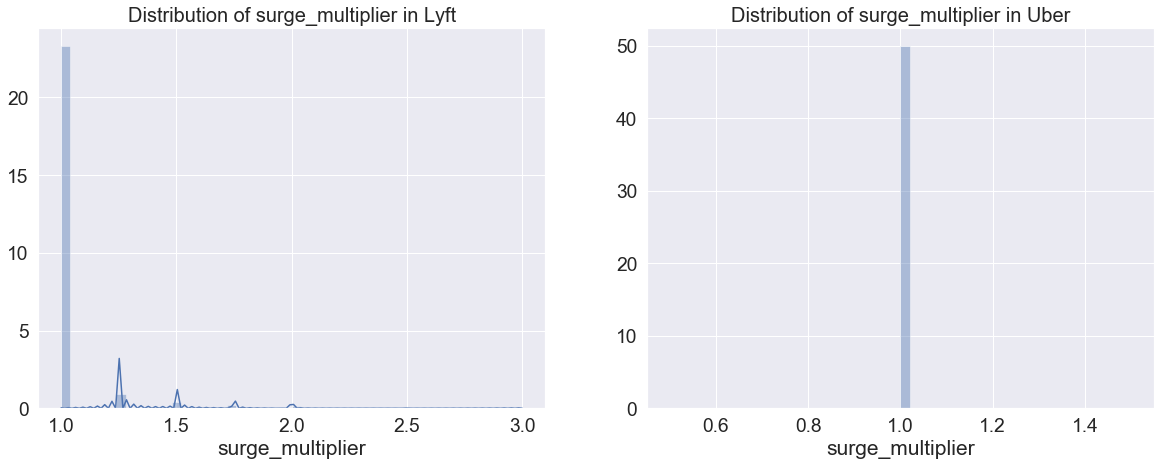

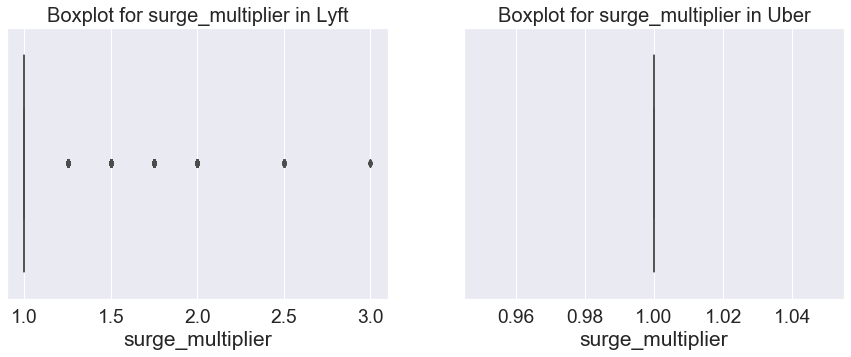

In [25]:
cab_data.loc[:,['distance','price','surge_multiplier']].apply(EDA_function,axis=0)
#cab_data.loc[:,['price']].apply(EDA_function,axis=0)

In [26]:
# Remove records below 0.25 as cancellation records
lyft[lyft['distance']<0.25] 

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour


In [27]:
uber[uber['distance']<0.25].sort_values(by='distance', ascending=False).head(5)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
454064,0.17,Uber,Theatre District,Boston University,7.0,1.0,2097d42a-27d0-4a0f-a407-8542b77b8659,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26,6
496855,0.17,Uber,Theatre District,Boston University,7.0,1.0,90ff317e-0320-4ca9-98da-14ee9277f4e7,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26,6
454068,0.17,Uber,Theatre District,Boston University,7.0,1.0,b92a6494-d162-42d2-bad5-bf522d14dc4e,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-26,6
165944,0.17,Uber,Theatre District,Boston University,7.0,1.0,1f22b687-4cbe-41fc-9dae-e74d9e0500a0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-26,6
564871,0.12,Uber,North End,West End,7.0,1.0,1ec52d61-8167-4a65-b15f-9a50f1723baa,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26,6


In [250]:
cab_data=cab_data[cab_data['distance']>=0.25]
uber=uber[uber['distance']>=0.25]
lyft=lyft[lyft['distance']>=0.25] 

From the above graphs, we can see that most of the rides are in the range of approximately 0.5 to 5.5 miles. 
The distribution is slightly right skewed in the both Lyft and Uber.
Distance in Lyft is more evenly dispersed than Uber.

**Outliers**       
Both the data contains some outliers, this may be due to weather conditions in which riders may have to travel extra distance than usual or occassionally riders tend to travel long distances. Outliers couldalso be due to use of high-end cars and high surge multipliers. Therefore, we decided to keep them.

In [251]:
lyft[(lyft['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
21322,3.98,Lyft,Financial District,Northeastern University,45.5,1.75,e61682b5-3b85-4260-a6bf-1f5c4737062f,lyft_premier,Lux,2018-12-13,12
35835,3.98,Lyft,Financial District,Northeastern University,45.5,1.00,c093cb2e-500c-4f58-b99f-6eaf96be1f7d,lyft_luxsuv,Lux Black XL,2018-12-13,15
481434,5.36,Lyft,Boston University,Financial District,45.5,1.00,f976343a-4df4-4e26-9ee6-afffaf2edcdd,lyft_luxsuv,Lux Black XL,2018-12-03,2


In [252]:
uber[(uber['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
658758,2.32,Uber,Haymarket Square,Back Bay,49.5,1.0,ce927ade-de26-4efc-ae06-7ae4032a8521,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-14,23
671389,5.70,Uber,Boston University,Financial District,43.0,1.0,24cc6b2b-b96d-4151-9e43-395d82e914c5,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-26,11
179879,4.44,Uber,Boston University,Financial District,41.5,1.0,bc646126-6380-4643-80ca-e21d30536561,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-29,4


**Outliers handling**      
We could see that, some rides are higher priced than usual for different car models. From our analysis, we can conclude that duration of the trip also has an impact on the price, and we do not posses data regarding the duration of the trip, so we cannot remove these outliers.

The price distribution is right skewed, from the boxplot we could see the outliers present in the data. On average, the price range varies from 5 to 40 US dollars, Outliers exists due to factors such as use of luxury cars, high city traffic and bad weather conditions.

**Categorical variables**

**Cab type**

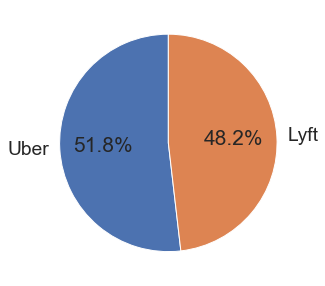

In [253]:
plt.figure(figsize=(8,5))

#Pie
Ncab_type = [cab_data.cab_type[(cab_data.cab_type)=='Uber'].count(),\
             cab_data.cab_type[(cab_data.cab_type)=='Lyft'].count()]
     
cab_type = ['Uber','Lyft']
plt.pie(Ncab_type, labels=cab_type, startangle=90, autopct='%.1f%%')
plt.show()

The dataset contains relatively higher proportion of Uber data, but we can say overall it is still balanced.

**Source, Destination and Name**

In [254]:
# function to perform basic EDA for input categorical variables
def EDA_cat_function(df):
    plt.figure(figsize=(8,5))
    sns.countplot(df[lyft_data])
    plt.title('Overall Frequency of '+df.name, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.countplot(df[lyft_data], ax=ax1)
    ax1.set_title('Frequency of '+df.name+' in Lyft', fontsize=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
    
    sns.countplot(df[uber_data], ax=ax2)
    ax2.set_title('Frequency of '+df.name+' in Uber', fontsize=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)
    return(1)

From the charts below, we see that, there is a variety of surge mulipliers in Lyft, whereas in Uber, there is only one surge multiplier. This can be a possible reason for increased number of riders in Uber, compared to Lyft. From the frequency plot, we could see that almost all the car models are used in similar frequency.

destination    1
source         1
name           1
dtype: int64

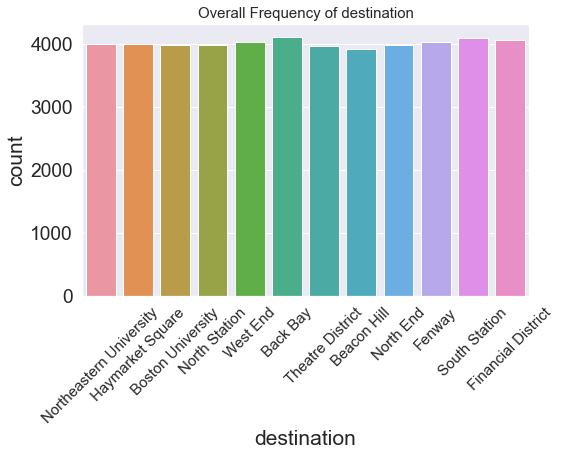

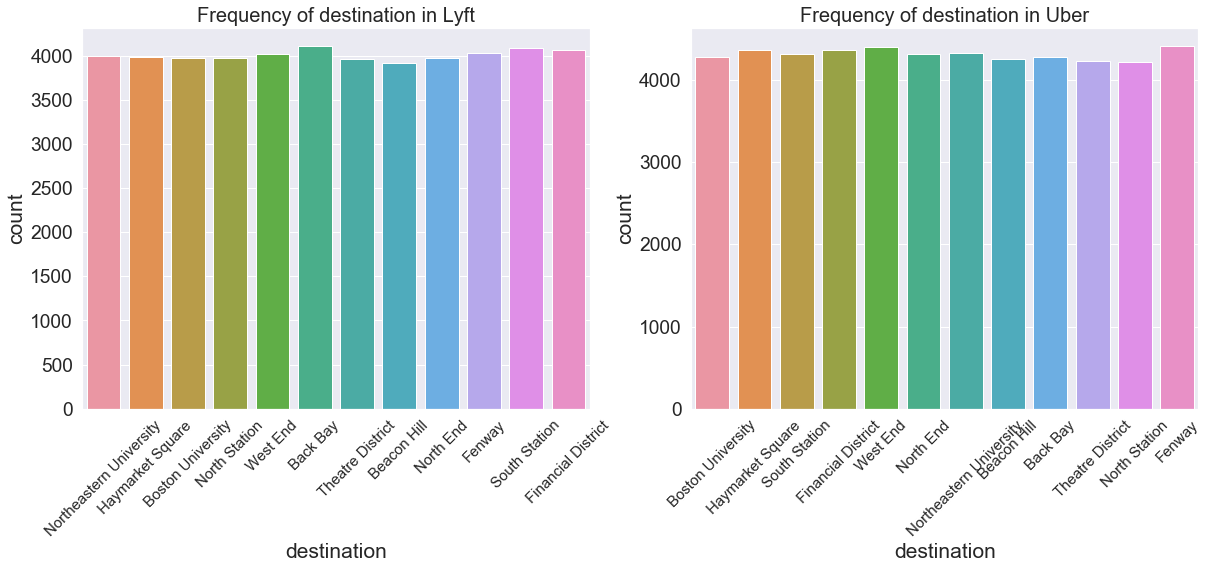

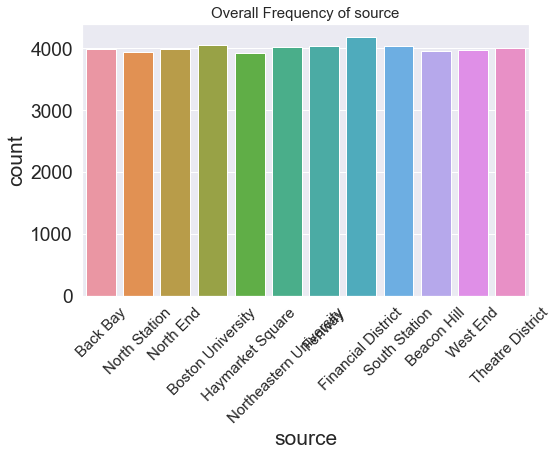

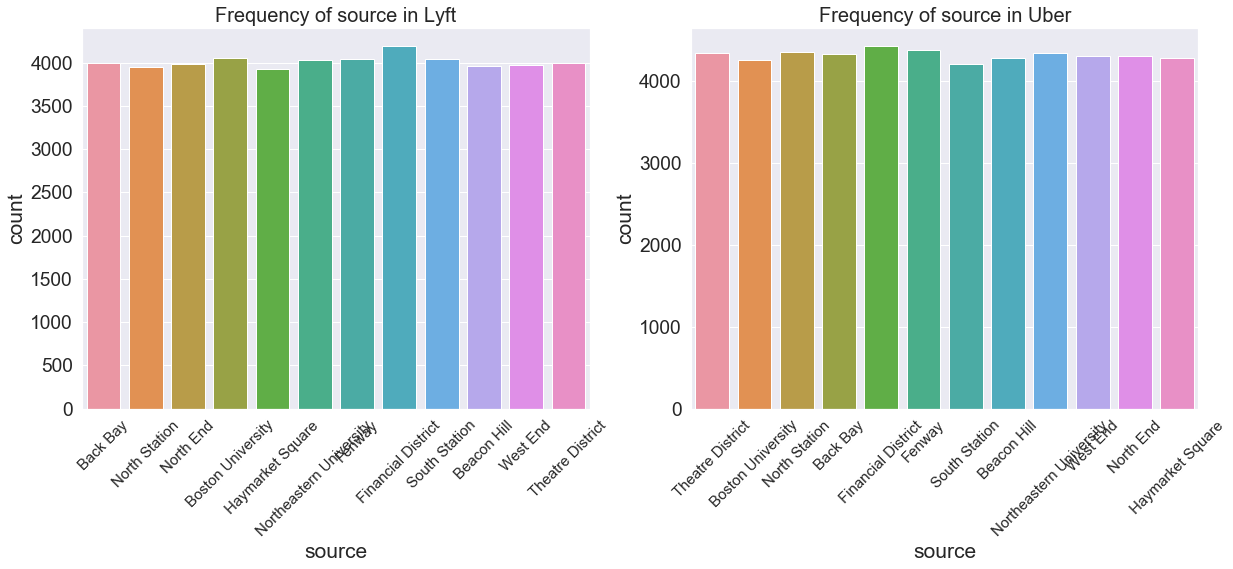

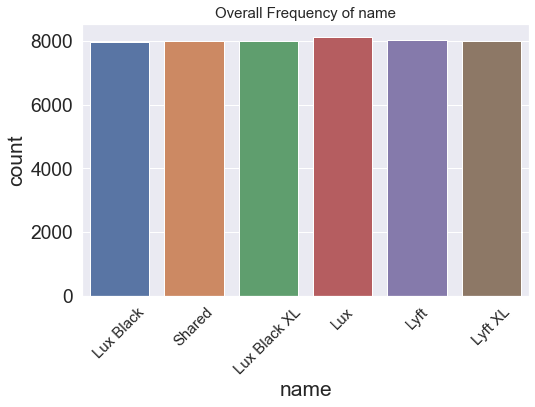

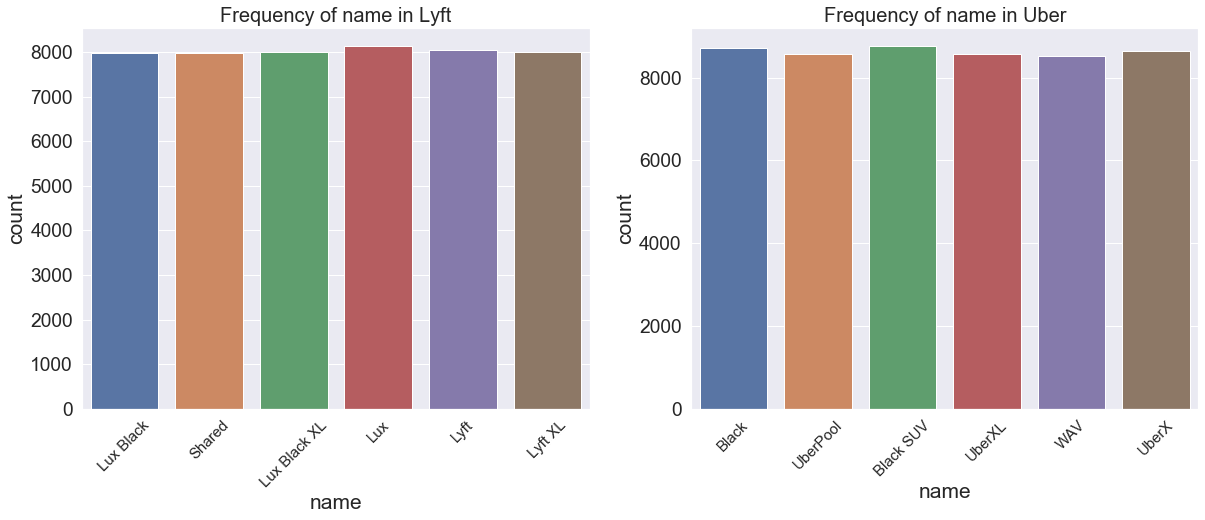

In [255]:
cab_data.loc[:,['destination','source','name']].apply(EDA_cat_function,axis=0)

## Price Vs Distance Analysis

(0, 100)

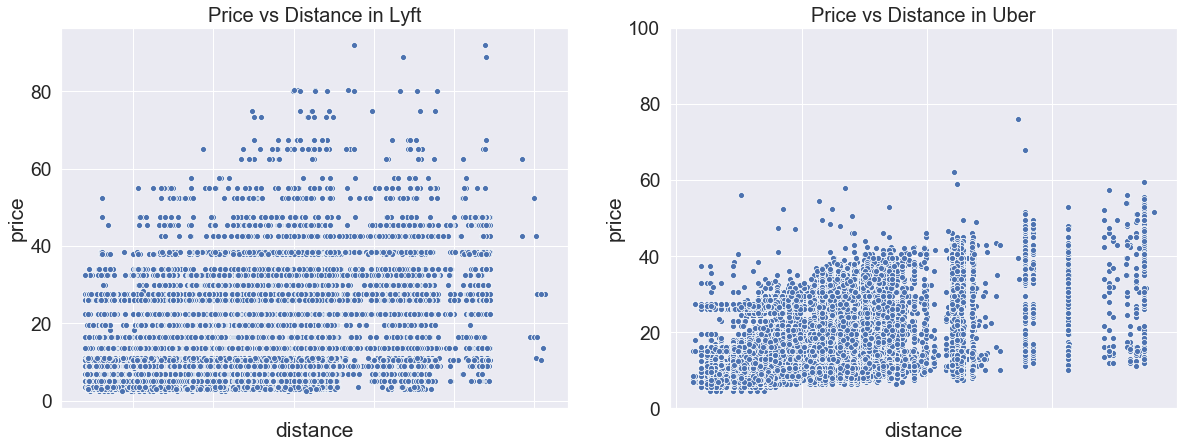

In [256]:
# scatterplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(lyft['distance'], lyft['price'], ax=ax1)
ax1.set_title('Price vs Distance in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(uber['distance'], uber['price'], ax=ax2)
ax2.set_title('Price vs Distance in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 100)

In [257]:
lyft['distance'].corr(lyft['price'])

0.367633653363266

In [258]:
uber['distance'].corr(uber['price'])

0.34333065328904616

Distance is one of the important factors, which drives the price of the rides.  We could see that there is a positive 
correlation in the graph, with the presence of outliers as we saw before, because of the use of luxury car models and 
bad weather conditions.

### Data Tables  - Get better sense of the data

**Cab type vs Surge multiplier**

In [259]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'])

surge_multiplier,1.0,1.25,1.5,1.75,2.0,2.5,3.0
cab_type,,,,,,,
Lyft,44858,1715,810,372,352,25,1
Uber,51802,0,0,0,0,0,0


We observe that surge multiplier is not available for uber data and only present in Lyft data.

**Car model vs Surge multiplier**

In [260]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'])

surge_multiplier,1.0,1.25,1.5,1.75,2.0,2.5,3.0
name,,,,,,,
Lux,7481,346,150,71,79,0,0
Lux Black,7315,343,157,94,64,0,0
Lux Black XL,7343,350,162,70,83,0,0
Lyft,7372,353,173,64,61,10,0
Lyft XL,7365,323,168,73,65,15,1
Shared,7982,0,0,0,0,0,0


## Weather dataset

In [261]:
weather_data.info() # basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
temp          6276 non-null float64
location      6276 non-null object
clouds        6276 non-null float64
pressure      6276 non-null float64
rain          6276 non-null float64
time_stamp    6276 non-null int64
humidity      6276 non-null float64
wind          6276 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.3+ KB


**Attribute Information**

Location - Location name              
Clouds              
Pressure - pressure in mb              
Rain - rain in inches for the last hr              
Time_stamp - epoch time when row data was collected              
Humidity - humidity in %              
Wind - wind speed in mph

### Feature category        
**Categorical**       
    - location
    
**Continuous**     
    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

### Univariate Analysis

In [262]:
# let's impute the time to standard date time format
weather_data['time_stamp'] = pd.to_datetime(weather_data['time_stamp'], unit='s')
weather_data['date'] = weather_data['time_stamp'].dt.date
weather_data['hour'] = weather_data['time_stamp'].dt.hour

weather_data.drop('time_stamp', axis=1, inplace=True)

In [263]:
weather_data.head(2)

,temp,location,clouds,pressure,rain,humidity,wind,date,hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16,23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16,23


### Continuous

**Temperature , Cloud, Pressure, Rain , Humidity and Wind**

In [264]:
num_lst=['temp','clouds','pressure','rain','humidity','wind']
weather_data.loc[:,num_lst].apply(lambda x : x.describe(),axis=0)

,temp,clouds,pressure,rain,humidity,wind
count,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.008212,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.043021,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000000,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.000000,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.000000,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.000000,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,0.990000,18.180000


In [265]:
cat_lst=['location']
weather_data.loc[:,cat_lst].apply(lambda x : x.describe(),axis=0)

,location
count,6276
unique,12
top,Back Bay
freq,523


In [266]:
# function to perform basic EDA for input columns
def EDA_weather(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.distplot(df[~df.isnull()], ax=ax1, kde=True)
    ax1.set_title('Distribution of '+df.name, fontsize=20)
    sns.boxplot(df[~df.isnull()], ax=ax2)
    ax2.set_title('Boxplot for '+df.name, fontsize=20)
    return(1)

temp        1
clouds      1
pressure    1
rain        1
humidity    1
wind        1
dtype: int64

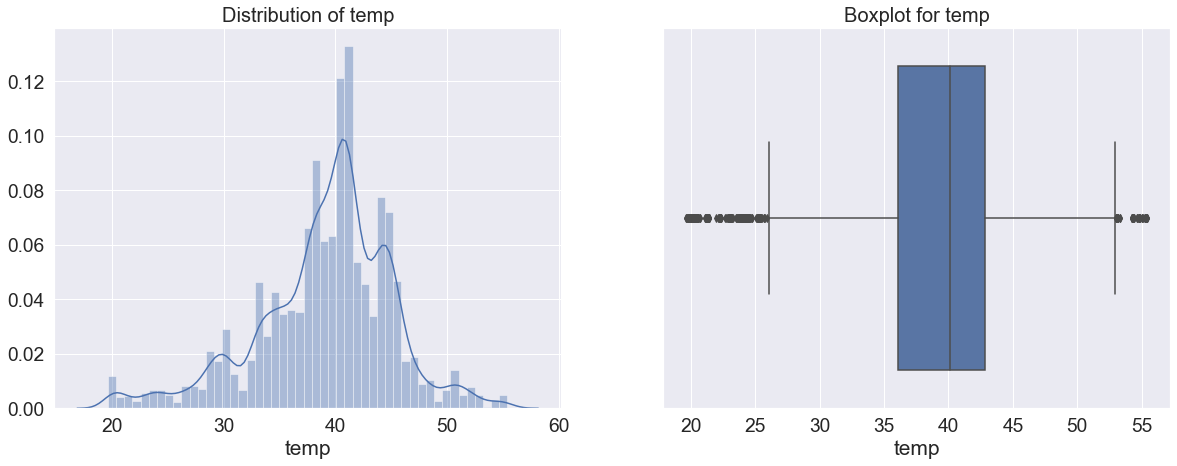

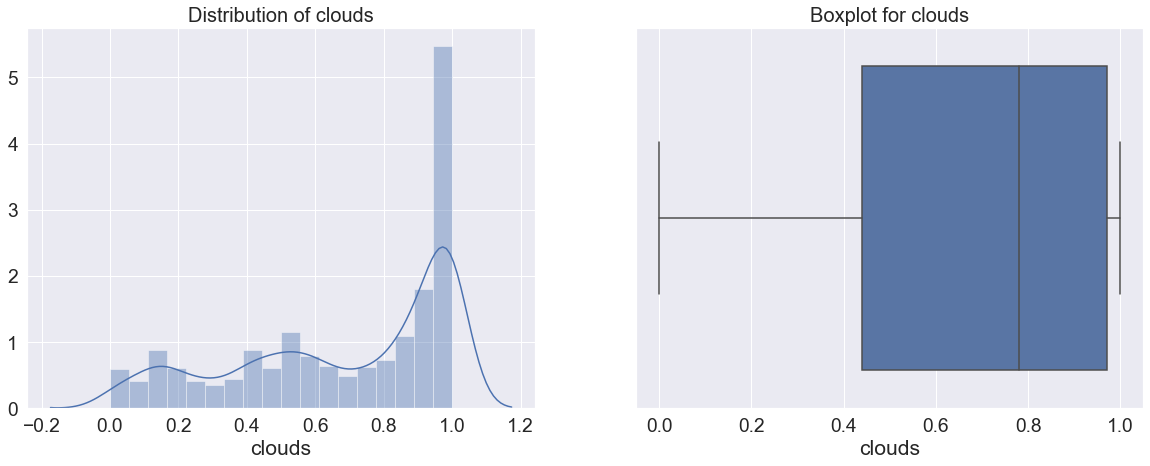

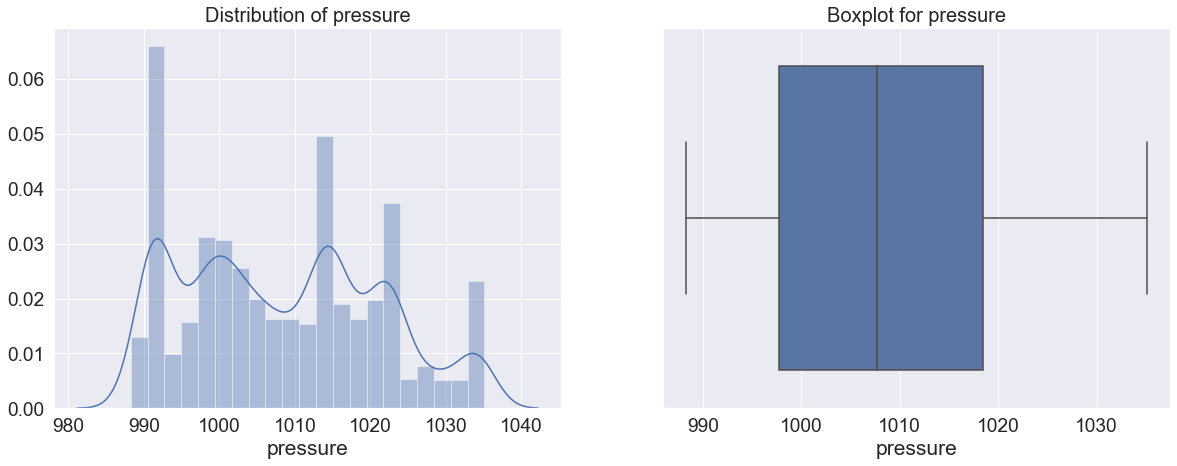

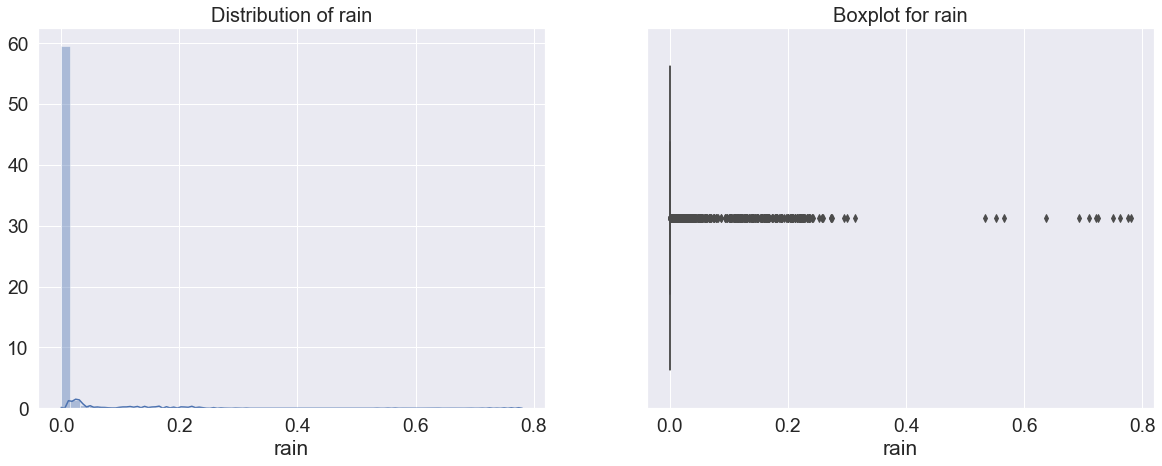

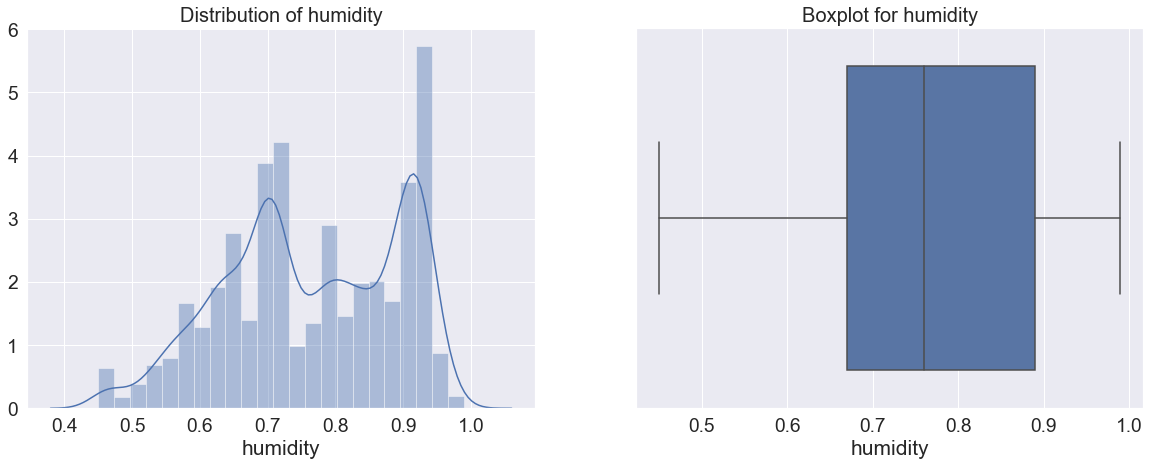

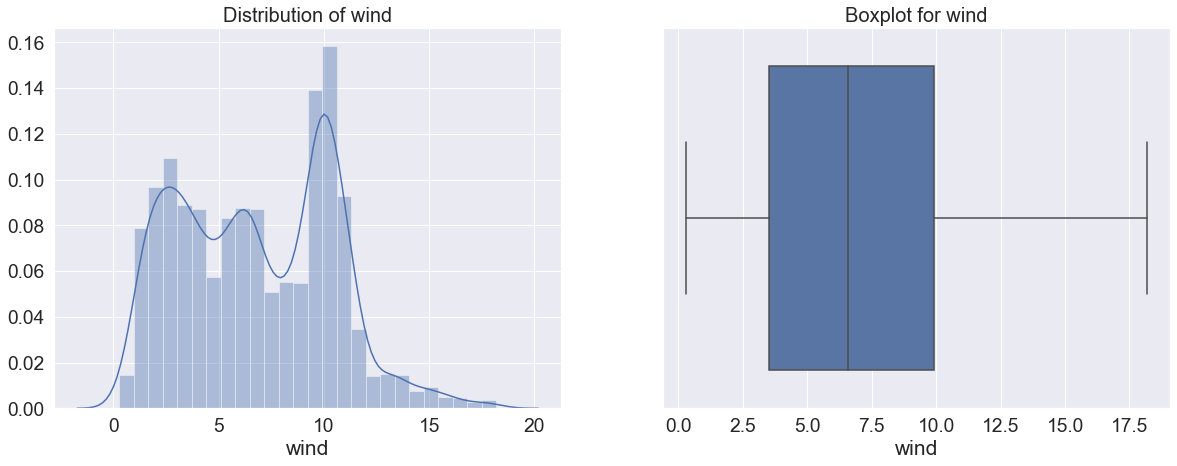

In [267]:
weather_data.loc[:,['temp','clouds','pressure','rain','humidity','wind']].apply(EDA_weather,axis=0)

In [268]:
weather_data[weather_data.temp < 26].date.value_counts()

2018-12-13    171
2018-12-18     48
Name: date, dtype: int64

In [269]:
weather_data[weather_data.temp > 53].date.value_counts()

2018-12-03    43
Name: date, dtype: int64

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018,
the data is legitimate. We can keep the outliers.

Temperature is slighty left skewed, and it makes sense, because this data is collected around the month of november,
although occassionally we can see high temperature as well in locations such as Financial district, Boston university
and Back bay.

In [270]:
weather_data[weather_data['rain']>0].date.value_counts()

2018-11-27    380
2018-12-02    137
2018-11-26    126
2018-12-17     75
2018-12-16     65
2018-11-29     42
2018-12-03     24
2018-11-28     23
2018-12-18     12
2018-12-01      9
2018-12-15      1
Name: date, dtype: int64

**Outliers handling**

Rain is right skewed, it is understandable as this data is collected for 17 days, only in few days, there was rain
in Boston city. So, we've decided not to remove these outliers.

### Bi-variate analysis

    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

**Continuous & Continuous**

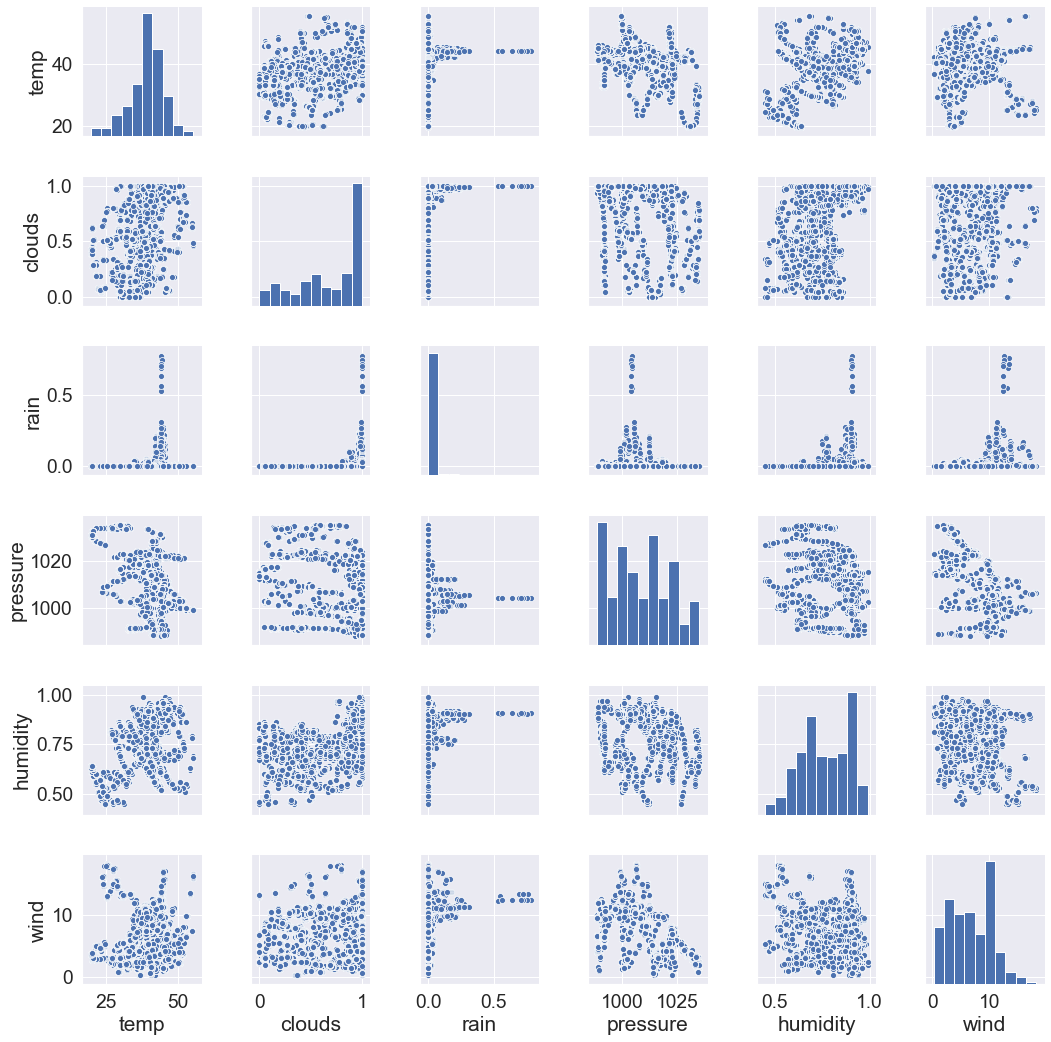

In [271]:
sns.pairplot(weather_data[['temp', 'clouds', 'rain', 'pressure', 'humidity', 'wind']])

**Categorical & Continuous**

In [272]:
def box_func(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df, y=weather_data['location'], orient='h')
    plt.title('Boxplot for location Vs '+df.name, fontsize=15)
    return(1)

temp        1
clouds      1
pressure    1
rain        1
humidity    1
wind        1
dtype: int64

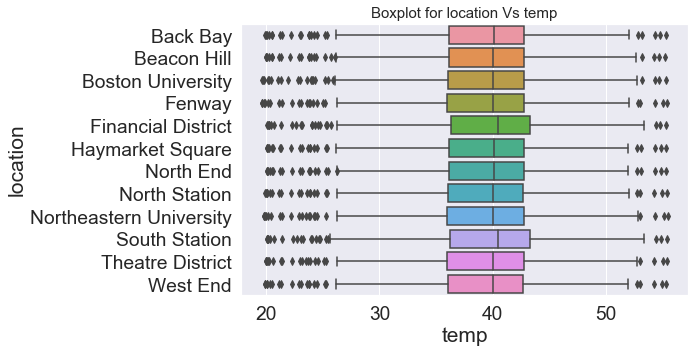

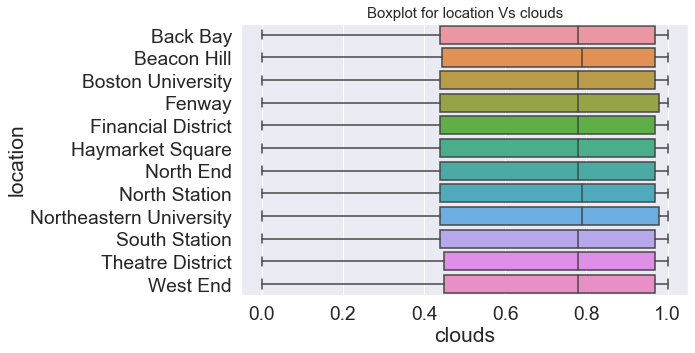

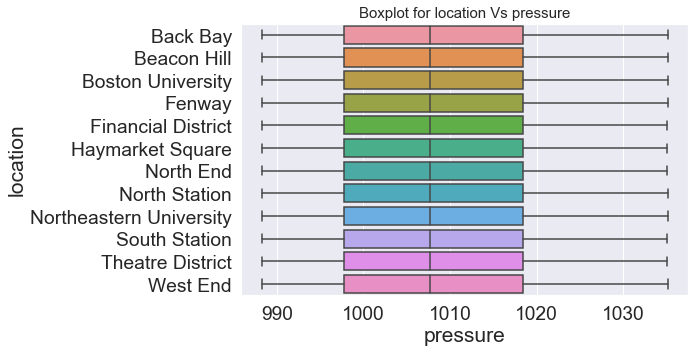

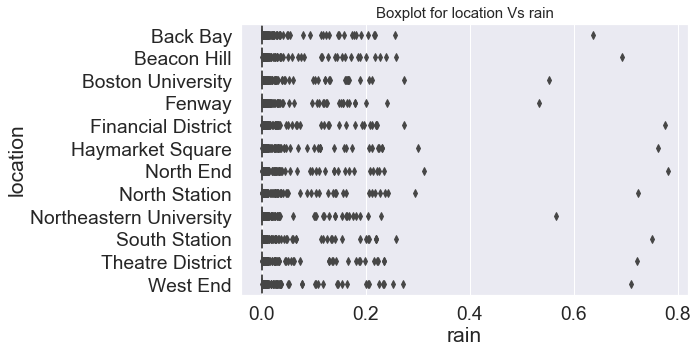

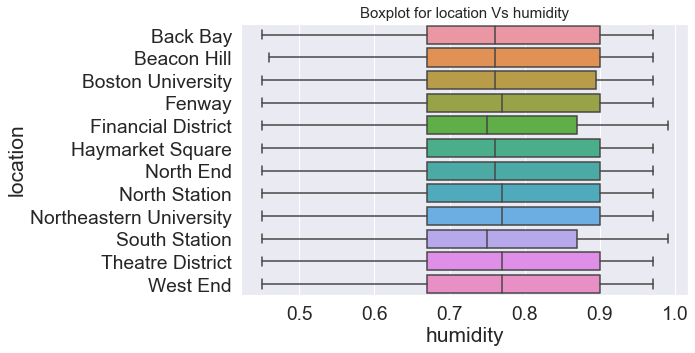

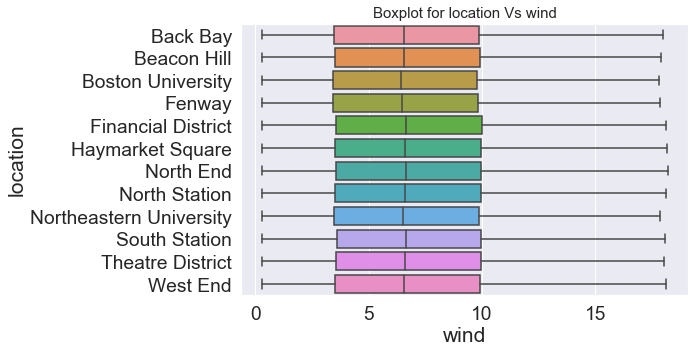

In [273]:
weather_data.loc[:,['temp','clouds','pressure','rain','humidity','wind']].apply(box_func,axis=0)

Since the data is collected within Boston city, the rain has effect on all the locations within the city,
among those locations such as Financial District, Haymarket Square and North end have experienced high rainfall.

### Model Preparation

In [274]:
# weather data supposed to contain 1 record per hour, since it has more than one values for few hours, 
# we took groupby average
weather_data = weather_data.groupby(['location','date', 'hour']).mean()
weather_data.reset_index(inplace=True)

In [275]:
#joining 2 datasets together
merged_data = pd.merge(cab_data, weather_data, how='left', left_on=['source', 'date', 'hour'],
        right_on=['location', 'date', 'hour'])

In [276]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99935 entries, 0 to 99934
Data columns (total 18 columns):
distance            99935 non-null float64
cab_type            99935 non-null object
destination         99935 non-null object
source              99935 non-null object
price               99935 non-null float64
surge_multiplier    99935 non-null float64
id                  99935 non-null object
product_id          99935 non-null object
name                99935 non-null object
date                99935 non-null object
hour                99935 non-null int64
location            99476 non-null object
temp                99476 non-null float64
clouds              99476 non-null float64
pressure            99476 non-null float64
rain                99476 non-null float64
humidity            99476 non-null float64
wind                99476 non-null float64
dtypes: float64(9), int64(1), object(8)
memory usage: 14.5+ MB


We could see that there is null values in the data.

In [277]:
merged_data[merged_data.temp.isnull()].groupby(['source', 'date', 'hour']).mean().head(6)

distance      price  surge_multiplier  temp  \
source      date       hour                                                
Back Bay    2018-11-28 1     1.430000   8.625000               1.0   NaN   
            2018-12-04 6     1.797778  14.736111               1.0   NaN   
            2018-12-18 19    4.613333  22.583333               1.0   NaN   
Beacon Hill 2018-11-28 1     1.616429  16.107143               1.0   NaN   
            2018-12-04 6     2.099091  15.022727               1.0   NaN   
            2018-12-18 19    2.532500  18.875000               1.0   NaN   

                             clouds  pressure  rain  humidity  wind  
source      date       hour                                          
Back Bay    2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN  
Beacon Hill 2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN

Weather data doesn't have records for this particular dates and hours, let's impute these values with the previous values.

In [278]:
df1 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==0)]

df2 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==5)]
df3 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==2)]
df4 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==7)]


lookup = pd.concat([df1, df2, df3, df4])
lookup = lookup.groupby(['hour', 'location', 'date']).mean().reset_index()
df5 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 18)) &
    (weather_data['hour']==18)]

lookup = pd.concat([lookup, df5])
lookup['hour'] += 1
lookup.reset_index(inplace=True)

C:\Users\himanshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [279]:
weather_data = pd.concat([weather_data, lookup], ignore_index=True) 

C:\Users\himanshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [280]:
cab_data = pd.merge(cab_data, weather_data, how='left',
                left_on=['source', 'date', 'hour'],
                right_on=['location', 'date', 'hour'])

In [281]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99935 entries, 0 to 99934
Data columns (total 19 columns):
distance            99935 non-null float64
cab_type            99935 non-null object
destination         99935 non-null object
source              99935 non-null object
price               99935 non-null float64
surge_multiplier    99935 non-null float64
id                  99935 non-null object
product_id          99935 non-null object
name                99935 non-null object
date                99935 non-null object
hour                99935 non-null int64
clouds              99935 non-null float64
humidity            99935 non-null float64
index               459 non-null float64
location            99935 non-null object
pressure            99935 non-null float64
rain                99935 non-null float64
temp                99935 non-null float64
wind                99935 non-null float64
dtypes: float64(10), int64(1), object(8)
memory usage: 15.2+ MB


In [282]:
cab_data.drop('index', axis=1, inplace=True)

In [283]:
cab_data.shape, cab_data.drop_duplicates().shape

((99935, 18), (99935, 18))

In [284]:
# drop unnecessary features
cab_data = cab_data.drop(['id', 'product_id', 'location', 'date'], axis=1)

In [285]:
# Initial data preparation
data = cab_data.drop(['price', 'surge_multiplier'], axis=1) # we are dropping surge multiplier, to avoid data leak
labels = cab_data['price'].copy()

In [286]:
# model building libraries

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [287]:
uber = cab_data[cab_data['cab_type']=='Uber']
uber.reset_index(inplace=True)
uber.drop('index', axis=1, inplace=True)
lyft = cab_data[cab_data['cab_type']=='Lyft']
lyft.reset_index(inplace=True)
lyft.drop('index', axis=1, inplace=True)

C:\Users\himanshu\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [288]:
uber.drop('cab_type', axis=1, inplace=True)
lyft.drop('cab_type', axis=1, inplace=True)

In [289]:
lyft_data = lyft.copy() # backups
uber_data = uber.copy()

In [290]:
uber_data.head(2)

,distance,destination,source,price,surge_multiplier,name,hour,clouds,humidity,pressure,rain,temp,wind
0,2.62,Boston University,Theatre District,22.0,1.0,Black,16,0.48,0.68,999.24,0.0,55.38,16.08
1,1.72,Haymarket Square,Theatre District,10.0,1.0,UberPool,16,0.27,0.66,1032.08,0.0,41.30,4.27


In [291]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51802 entries, 0 to 51801
Data columns (total 13 columns):
distance            51802 non-null float64
destination         51802 non-null object
source              51802 non-null object
price               51802 non-null float64
surge_multiplier    51802 non-null float64
name                51802 non-null object
hour                51802 non-null int64
clouds              51802 non-null float64
humidity            51802 non-null float64
pressure            51802 non-null float64
rain                51802 non-null float64
temp                51802 non-null float64
wind                51802 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 5.1+ MB


**Categorical columns encoding**

**One Hot encoding**

In [292]:
ohe = OneHotEncoder()
car_type = pd.DataFrame(ohe.fit_transform(uber[['name']]).toarray(), columns=sorted(list(uber['name'].unique())))
source = pd.DataFrame(ohe.fit_transform(uber[['source']]).toarray(), 
                       columns=['src_'+loc for loc in sorted(list(uber['source'].unique()))])
destination = pd.DataFrame(ohe.fit_transform(uber[['destination']]).toarray(), 
                           columns=['dest_'+loc for loc in sorted(list(uber['destination'].unique()))])

In [293]:
ohe = OneHotEncoder()
lyft_car_type = pd.DataFrame(ohe.fit_transform(lyft[['name']]).toarray(), columns=sorted(list(lyft['name'].unique())))
lyft_source = pd.DataFrame(ohe.fit_transform(lyft[['source']]).toarray(),
                           columns=['src_'+loc for loc in sorted(list(lyft['source'].unique()))])
lyft_destination = pd.DataFrame(ohe.fit_transform(lyft[['destination']]).toarray(),
                                columns=['dest_'+loc for loc in sorted(list(lyft['destination'].unique()))])

In [294]:
uber = pd.concat([uber, car_type, source, destination], axis=1)
uber.drop(['name', 'source', 'destination'], axis=1, inplace=True)

In [295]:
lyft = pd.concat([lyft, lyft_car_type, lyft_source, lyft_destination], axis=1)
lyft.drop(['name', 'source', 'destination'], axis=1, inplace=True)

**Label Encoding**

In [296]:
from sklearn.preprocessing import LabelEncoder

In [297]:
uber_le = uber_data.copy()
lyft_le = lyft_data.copy()

lb = LabelEncoder()

uber_le['name'] = lb.fit_transform(uber_data['name'])
uber_le['source'] = lb.fit_transform(uber_data['source'])
uber_le['destination'] = lb.fit_transform(uber_data['destination'])

lyft_le['name'] = lb.fit_transform(lyft_le['name'])
lyft_le['source'] = lb.fit_transform(lyft_le['source'])
lyft_le['destination'] = lb.fit_transform(lyft_le['destination'])

In [298]:
uber_leX = uber_le.drop(['price', 'surge_multiplier'], axis=1)
uber_ley = uber_le['price'].copy()

lyft_leX = lyft_le.drop(['price', 'surge_multiplier'], axis=1)
lyft_ley = lyft_le['price'].copy()

In [299]:
uber_X = uber.drop(['price', 'surge_multiplier'], axis=1)
uber_y = uber['price'].copy()

In [300]:
lyft_X = lyft.drop(['price', 'surge_multiplier'], axis=1)
lyft_y = lyft['price'].copy()

In [301]:
uber_leX.shape

(51802, 11)

In [302]:
lyft_leX.shape

(48133, 11)

## Feature Selection

### 1. Correlation

In [303]:
lyft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48133 entries, 0 to 48132
Data columns (total 13 columns):
distance            48133 non-null float64
destination         48133 non-null object
source              48133 non-null object
price               48133 non-null float64
surge_multiplier    48133 non-null float64
name                48133 non-null object
hour                48133 non-null int64
clouds              48133 non-null float64
humidity            48133 non-null float64
pressure            48133 non-null float64
rain                48133 non-null float64
temp                48133 non-null float64
wind                48133 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 4.8+ MB


**Lyft**

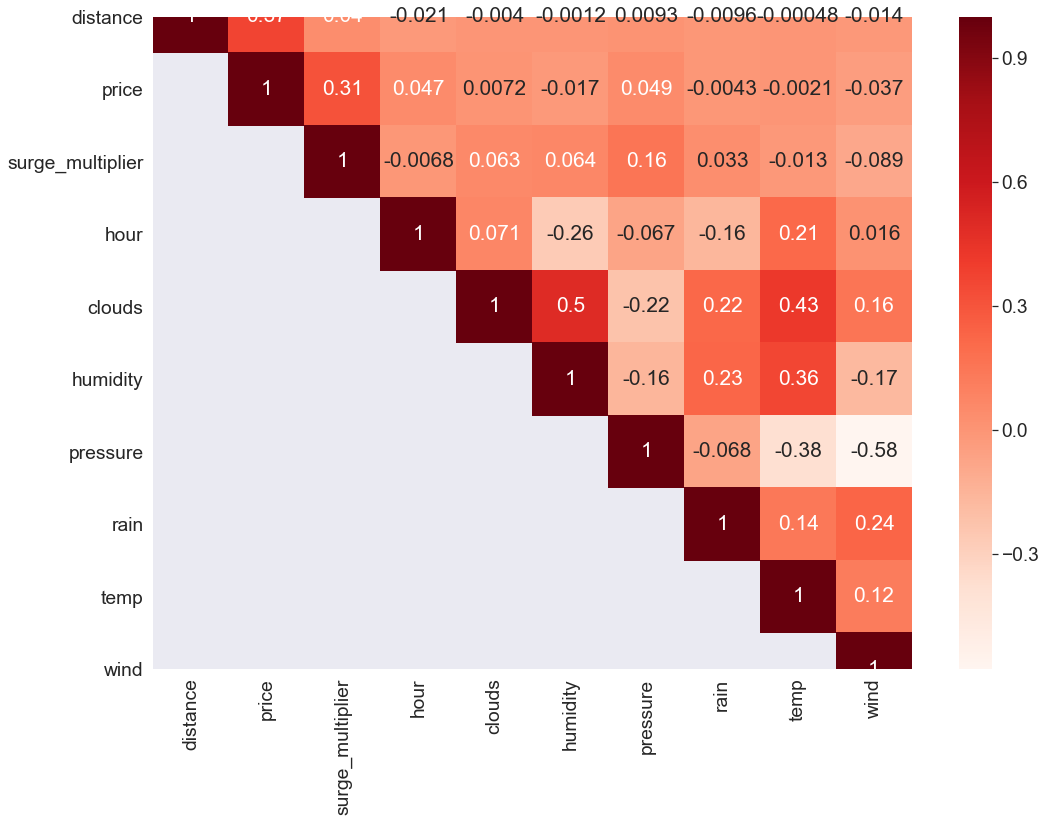

In [455]:
plt.figure(figsize=(15,10))
corr_m = lyft_data.corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [305]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance            0.367634
surge_multiplier    0.313958
pressure            0.048567
hour                0.047037
wind                0.037116
humidity            0.017132
clouds              0.007248
rain                0.004304
temp                0.002122
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind. (we can ignore surge multiplier, as it leaks info about price.)          
Rain and temperature are not significant.

**Uber**

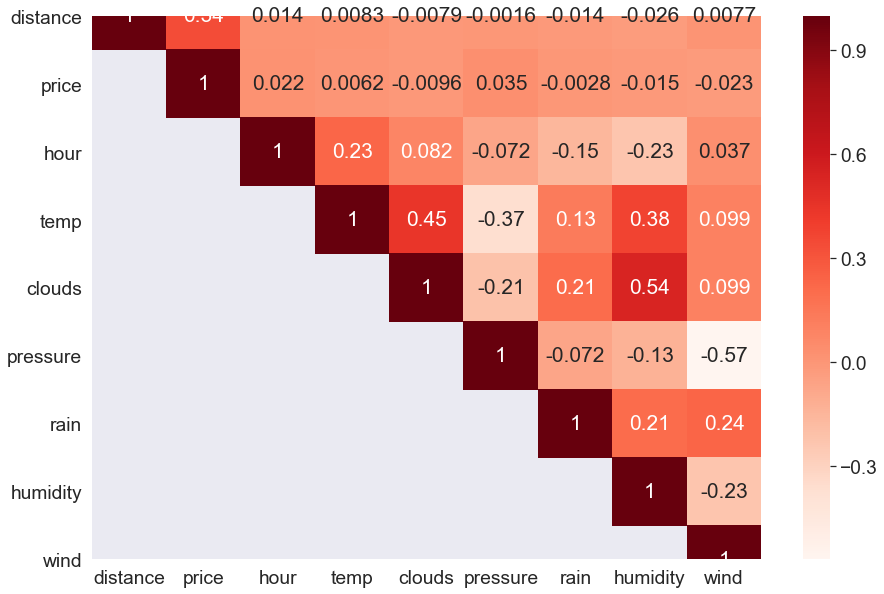

In [456]:
plt.figure(figsize=(15,10))
corr_m = uber_data[['distance', 'destination', 'source', 'price','name', 'hour', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind']].corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [307]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance    0.343331
pressure    0.035084
wind        0.022915
hour        0.022260
humidity    0.014549
clouds      0.009562
temp        0.006191
rain        0.002841
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind.          
Rain and clouds are not significant.

In [308]:
uber1_X = uber_X.copy()
uber1_y = uber_y.copy()

In [309]:
lyft1_X = lyft_X
lyft1_y = lyft_y

### 2. Lasso

In [310]:
from sklearn.linear_model import LassoCV

**Uber**

In [311]:
reg = LassoCV()
reg.fit(uber1_X, uber1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(uber1_X,uber1_y))
coef = pd.Series(reg.coef_, index = uber1_X.columns)
coef

C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.003976
Best score using built-in LassoCV: 0.926010


distance                         2.521084
hour                             0.024773
clouds                           0.000000
humidity                        -0.000000
pressure                         0.033530
rain                             0.000000
temp                             0.024829
wind                             0.011294
Black                            7.948862
Black SUV                       17.679659
UberPool                        -3.797136
UberX                           -2.818064
UberXL                           3.014986
WAV                             -2.826880
src_Back Bay                    -0.044298
src_Beacon Hill                 -0.261669
src_Boston University           -0.157423
src_Fenway                      -0.092374
src_Financial District           0.325522
src_Haymarket Square             0.402976
src_North End                    0.470388
src_North Station                0.002506
src_Northeastern University     -0.370560
src_South Station                0

In [312]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 32 variables and eliminated the other 6 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

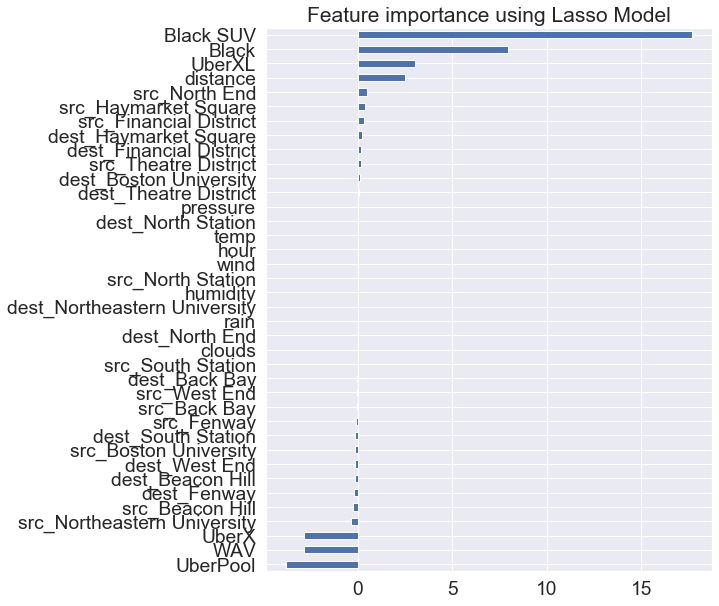

In [313]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

**Lyft**

In [314]:
reg = LassoCV()
reg.fit(lyft1_X, lyft1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(lyft1_X, lyft1_y))
coef = pd.Series(reg.coef_, index = lyft1_X.columns)
coef

C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.006647
Best score using built-in LassoCV: 0.882017


distance                         3.453054
hour                             0.076174
clouds                           0.455536
humidity                        -0.000000
pressure                         0.038728
rain                             0.000000
temp                             0.007278
wind                             0.005604
Lux                              2.349763
Lux Black                        7.663022
Lux Black XL                    16.919367
Lyft                            -5.703913
Lyft XL                         -0.000000
Shared                          -9.309806
src_Back Bay                     0.638888
src_Beacon Hill                 -0.333772
src_Boston University           -0.346952
src_Fenway                       0.000000
src_Financial District           0.000000
src_Haymarket Square            -0.100893
src_North End                    0.000000
src_North Station               -0.467686
src_Northeastern University      0.000000
src_South Station                0

In [315]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 27 variables and eliminated the other 11 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

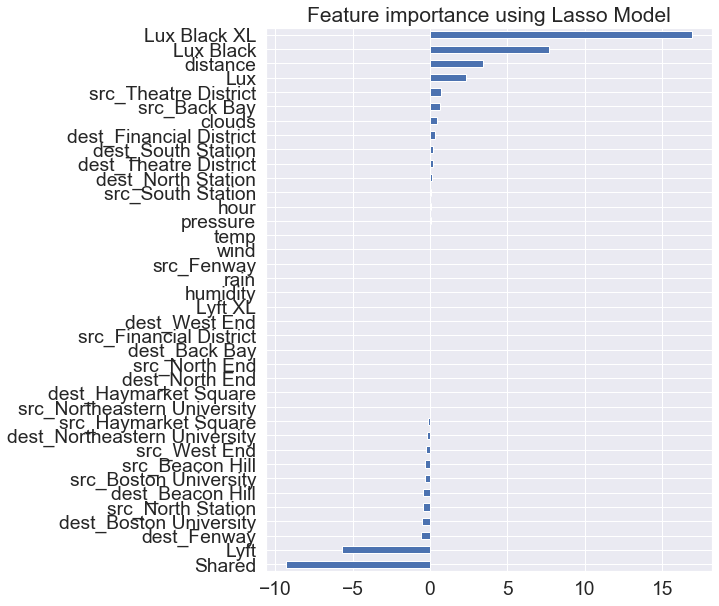

In [316]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Feature transformation

#### Scaling

In [317]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

uber_std = pd.DataFrame(sc.fit_transform(uber_X[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

lyft_std = pd.DataFrame(sc.fit_transform(lyft_X[['distance', 'hour', 'pressure', 'rain']]),
                        columns=['distance', 'hour', 'pressure', 'rain'])

uber_X = uber_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)
lyft_X = lyft_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

uber_X = pd.concat([uber_std, uber_X], axis=1)
lyft_X = pd.concat([lyft_std, lyft_X], axis=1)

C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\himanshu\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Model Building

In [480]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

### 1. Linear Regression

**Uber**

In [481]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

In [482]:
lin_reg_uber = LinearRegression()
lin_reg_uber.fit(X_trainu, y_trainu)

# print(f'Train score : {lin_reg_uber.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lin_reg_uber.predict(X_trainu)))}')
predicted = lin_reg_uber.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 2.33861628606942
Test score : 2.343945548889717


In [483]:
train_cv = cross_val_score(LinearRegression(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_uber = {}
l_reg_uber['Train'] = round(train_rmse, 4)
l_reg_uber['Test'] = round(test_rmse, 4)
l_reg_uber

{'Train': 2.3401, 'Test': 2.3424}

In [484]:
# R squared for model
l_reg_uber['R2'] = r2_score(y_testu, predicted)
l_reg_uber['R2']

0.9260993655307634

**Lyft**

In [485]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

In [486]:
lin_reg_lyft = LinearRegression()
lin_reg_lyft.fit(X_trainl, y_trainl)

# print(f'Train score : {lin_reg_lyft.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lin_reg_lyft.predict(X_trainl)))}')
predicted = lin_reg_lyft.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 3.391199611513132
Test score : 3.5867120482744466


In [487]:
train_cv = cross_val_score(LinearRegression(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_lyft = {}
l_reg_lyft['Train'] = round(train_rmse, 4)
l_reg_lyft['Test'] = round(test_rmse, 4)
l_reg_lyft

{'Train': 3.3942, 'Test': 3.587}

In [488]:
# R squared for model
l_reg_lyft['R2'] = r2_score(y_testl, predicted)
l_reg_lyft['R2']

0.877522725668257

### 2. Lasso

**Uber**

In [489]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainu, y_trainu)
lasso_reg_predict = lasso_reg.predict(X_testu)

# print(f'Train score : {lasso_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu)))}')
predicted = lasso_reg.predict(X_testu)
# print(np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu))))
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.433761680861891
Test score : 5.4726750126881365


In [490]:
train_cv = cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_uber = {}
la_reg_uber['Train'] = round(train_rmse, 4)
la_reg_uber['Test'] = round(test_rmse, 4)
la_reg_uber

{'Train': 5.4341, 'Test': 5.4188}

In [491]:
# R squared for model
la_reg_uber['R2'] = r2_score(y_testu, predicted)
la_reg_uber['R2']

0.5971415775693035

**Hyperparameter Tuning**

In [492]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
#grid_search.fit(X_trainu,y_trainu)
#grid_search.best_estimator_

**Lyft**

In [493]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainl, y_trainl)

# print(f'Train score : {lasso_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lasso_reg.predict(X_trainl)))}')
predicted = lasso_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(random_state=42), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 6.1514148246333535
Test score : 6.349754825653951


In [494]:
train_cv = cross_val_score(Lasso(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_lyft = {}
la_reg_lyft['Train'] = round(train_rmse, 4)
la_reg_lyft['Test'] = round(test_rmse, 4)
la_reg_lyft

{'Train': 6.152, 'Test': 6.2406}

In [495]:
# R squared for model
la_reg_lyft['R2'] = r2_score(y_testl, predicted)
la_reg_lyft['R2']

0.616136867424989

**HyperParameter Tuning**

In [496]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
#grid_search.fit(X_trainl,y_trainl)
#grid_search.best_estimator_

### 3. Decision Trees

**Uber**

In [497]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_leX, uber_ley, test_size=0.3, random_state=42)

In [498]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 0.28387917320126205
Test score : 1.9998648522372795


In [499]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainu, y_trainu)
    train_pred = dt.predict(X_trainu)
    rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testu)
    ts_rmse = np.sqrt(mean_squared_error(y_testu, y_pred))
    test_results.append(ts_rmse)

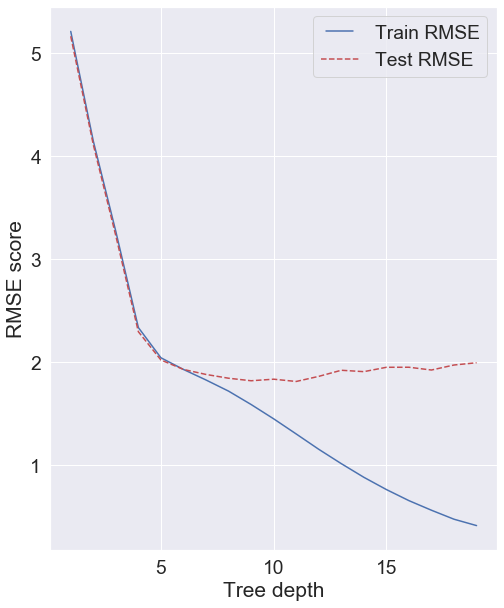

In [500]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

Let's choose 4 as max depth

In [501]:
dtree = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 3.8811899846521003
Test score : 3.86351679922925


In [502]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_uber = {}
dt_reg_uber['Train'] = round(train_rmse, 4)
dt_reg_uber['Test'] = round(test_rmse, 4)
dt_reg_uber

{'Train': 2.0843, 'Test': 2.2139}

In [503]:
# R squared for model
dt_reg_uber['R2'] = r2_score(y_testu, predicted)
dt_reg_uber['R2']

0.7992207905879604

**HyperParameter tuning**

In [504]:
param_grid = {'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [505]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
#grid_srch_dtree.fit(X_trainu, y_trainu)
#grid_srch_dtree.best_estimator_

**Lyft**

In [506]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_leX, lyft_ley, test_size=0.3, random_state=42)

In [507]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainl, y_trainl)
    train_pred = dt.predict(X_trainl)
    rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testl)
    ts_rmse = np.sqrt(mean_squared_error(y_testl, y_pred))
    test_results.append(ts_rmse)

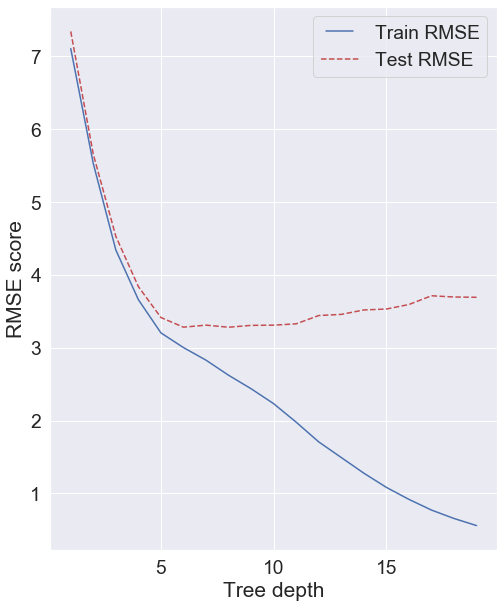

In [508]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

In [509]:
dtree = DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

dtree.fit(X_trainl, y_trainl)

train_pred = dtree.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train score : 4.706089277941515
Test score : 4.920934379006178


In [510]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_lyft = {}
dt_reg_lyft['Train'] = round(train_rmse, 4)
dt_reg_lyft['Test'] = round(test_rmse, 4)
dt_reg_lyft

{'Train': 3.4484, 'Test': 4.0446}

In [511]:
# R squared for model
dt_reg_lyft['R2'] = r2_score(y_testl, predicted)
dt_reg_lyft['R2']

0.7694539758990806

**HyperParameter tuning**

In [512]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
#grid_srch_dtree.fit(X_trainl, y_trainl)
#grid_srch_dtree.best_estimator_

### 4. Random Forest

In [513]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.cross

In [514]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

rf.fit(X_trainu, y_trainu)

train_pred = rf.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 0.8831561314411723
Test score : 1.507038045757874
[1.61195615 1.63136696 1.5811316  1.6396859  1.61003601]


In [515]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_uber = {}
rf_reg_uber['Train'] = round(train_rmse, 4)
rf_reg_uber['Test'] = round(test_rmse, 4)
rf_reg_uber

{'Train': 1.6114, 'Test': 1.764}

In [516]:
# R squared for model
rf_reg_uber['R2'] = r2_score(y_testu, predicted)
rf_reg_uber['R2']

0.9694506789475352

**Hyper Parameter Tuning**

In [517]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 6, 8, 10, 11, 13, 15, 16, 18, 20, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [518]:
X_trainl.shape

(33693, 11)

In [519]:
# Random search of parameters, using 10 fold cross validation, 
# search across 10000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_trainu, y_trainu)

In [520]:
#rf_random.best_estimator_

**Lyft data**

In [521]:
rf = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf.fit(X_trainl, y_trainl)

train_pred = rf.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 1.132455437686255
Test score : 2.6780993158761444
[2.8768771  2.67237458 2.72900223 2.68331221 2.73371645]


In [522]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_lyft = {}
rf_reg_lyft['Train'] = round(train_rmse, 4)
rf_reg_lyft['Test'] = round(test_rmse, 4)
rf_reg_lyft

{'Train': 2.7334, 'Test': 3.147}

In [523]:
# R squared for model
rf_reg_lyft['R2'] = r2_score(y_testl, predicted)
rf_reg_lyft['R2']

0.931716488519962

**Hyper Parameter Tuning**

In [524]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 6, 8, 10, 11, 13, 15, 16, 18, 20, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [525]:
X_trainl.shape

(33693, 11)

In [526]:
# Random search of parameters, using 10 fold cross validation, 
# search across 10000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_trainl, y_trainl)

In [527]:
#rf_random.best_estimator_

### 5. Boosting - Ada Boost

In [528]:
from sklearn.ensemble import AdaBoostRegressor

In [529]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainu, y_trainu)

train_pred = abr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.049722785049988
Test score : 5.090295646535289
[4.87951044 5.00705466 5.36463271 4.98002585 4.96818992]


In [530]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_uber = {}
abr_reg_uber['Train'] = round(train_rmse, 4)
abr_reg_uber['Test'] = round(test_rmse, 4)
abr_reg_uber

{'Train': 4.9026, 'Test': 4.2342}

In [531]:
# R squared for model
abr_reg_uber['R2'] = r2_score(y_testu, predicted)
abr_reg_uber['R2']

0.6514708203797579

In [532]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainl, y_trainl)

train_pred = abr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 6.310027633860267
Test score : 6.401002501431692
[6.89114804 7.11443733 6.13900306 6.34171429 6.19227988]


In [533]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_lyft = {}
abr_reg_lyft['Train'] = round(train_rmse, 4)
abr_reg_lyft['Test'] = round(test_rmse, 4)
abr_reg_lyft

{'Train': 6.5262, 'Test': 6.2146}

In [534]:
# R squared for model
abr_reg_lyft['R2'] = r2_score(y_testl, predicted)
abr_reg_lyft['R2']

0.6099156891954187